# Introduction

Hi! In this notebook I aim to reproduce the results of the paper "TAIL-GAN: Learning to Simulate Tail Risk Scenarios" by Cont et al. (2025). I'd summarize the key contribution in a broader ML context of this paper as follows:


**They found a way to train a Generator in a GAN such that it is more aware of the tails of the distribution it is learning, by projecting the multi-dimensional distribution to 1-dimensional distributions and characterizing the loss by the quantile function of this 1D distribution.**


To give some context:


In finance, when we test trading strategies we want to be aware of the "tail risk", i.e. the expected money loss if things are going really bad at the market. For this purpose, one usually estimated what is known as "Value at Risk" (VaR), which is the quintile function at $\alpha = 0.05$ of the profit and loss (PnL) distribution.

Now the PnL distribution in realistic market scenarios is understood to be "fat tailed", meaning that if we imagine it to be similar to a normal distribution, its tails (related to kurtosis) have a higher probability density compared to a simple normal distribution. In other words, events at the tails of the distribution (large losses or large profits) are more likely than they would be if things were normally distributed.

Now what Risk Quants do, is they try to imitate these fat tailed distributions.

# Imports and Installations

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from typing import Optional, Tuple, Literal, Union
import math

from scipy.stats import chi2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
!python --version

Python 3.12.12


# Synthetic Data

Because we don't have access to the intraday trading data used in the paper, we'll focus on reproducing the parts using synthetic trading data. (Which is the majority of the paper)

The paper uses a stochastic process of dimension 5 with each component having a different marginal probability distribution to simulate stock returns:

1. IID normal distribution
2. AR with $\psi_1 = 0.5$
3. AR with $\psi_2 = -0.5$
4. GARCH(1,1) with student-t ($\nu_1 = 5$) distribution
5. GARCH(1,1) with student-t ($\nu_2 = 10$) distribution

all of them are correlated by an underlying Gaussian innovation vector $\mathbf{u}_t \sim \mathcal{N}(0,\Sigma)$ whose covariance matrix is constructed from a randomly drawn correlation matrix $\rho_{ij}$ and some scaling factors related to annualized standard deviations (i.e. a realistic volatility measure) normalized to the time frame that the series is supposed to represent.

In what follows we write a simple code that produces this dataset.



In [ ]:
from scipy.stats import chi2

def project_to_correlation_psd(R):
  """
  This is to make sure the correlation matrix we create is positive semidefinite

  """
  R = 0.5 * (R + R.T)
  vals, vecs = np.linalg.eigh(R)
  vals_clipped = np.maximum(vals, 1e-8)
  R_psd = (vecs * vals_clipped) @ vecs.T
  d = np.sqrt(np.clip(np.diag(R_psd), 1e-12, None))
  Dinv = np.diag(1.0 / d)
  C = Dinv @ R_psd @ Dinv
  np.fill_diagonal(C, 1.0)
  return C

def simulate_X_series(L, T=100, phi1=0.5, phi2=-0.15, nu1=5, nu2=10, seed=0):
    # Correlation Matrix
    rng = np.random.default_rng(seed)
    s = rng.uniform(0.3, 0.5, size=5)
    rho = rng.uniform(0.0, 1.0, size=(5,5))
    rho = project_to_correlation_psd(rho)

    # Gaussian Vector and Process Parameters
    Sigma = np.outer(s, s) * rho / (255.0 * T)
    u = rng.multivariate_normal(mean=np.zeros(5), cov=Sigma, size=L)
    kappa4, kappa5 = rng.uniform(0.08, 0.12, size=2)
    beta4, beta5   = rng.uniform(0.825, 0.875, size=2)
    gamma4, gamma5 = rng.uniform(0.03, 0.07, size=2)
    X = np.zeros((L, 5))
    sigma4 = np.zeros(L)
    sigma5 = np.zeros(L)
    var4_0 = gamma4 / max(1e-8, (1.0 - kappa4 - beta4))
    var5_0 = gamma5 / max(1e-8, (1.0 - kappa5 - beta5))
    sigma4[0] = np.sqrt(var4_0)
    sigma5[0] = np.sqrt(var5_0)

    # Simulation of Processes
    for t in range(1, L):
        # 1) IID Normal
        X[t, 0] = u[t, 0]
        # 2) AR 0.5
        X[t, 1] = phi1 * X[t-1, 1] + u[t, 1]
        # 3) AR -0.15
        X[t, 2] = phi2 * X[t-1, 2] + u[t, 2]
        # 4 & 5) GARCH
        v1 = chi2.rvs(df=nu1, random_state=rng)
        v2 = chi2.rvs(df=nu2, random_state=rng)
        eta4 = u[t, 3] / np.sqrt(v1 / nu1)
        eta5 = u[t, 4] / np.sqrt(v2 / nu2)
        sigma4[t] = np.sqrt(gamma4 + kappa4 * X[t-1, 3]**2 + beta4 * sigma4[t-1]**2)
        sigma5[t] = np.sqrt(gamma5 + kappa5 * X[t-1, 4]**2 + beta5 * sigma5[t-1]**2)
        X[t, 3] = sigma4[t] * eta4
        X[t, 4] = sigma5[t] * eta5
    return X, s, rho, (kappa4, beta4, gamma4), (kappa5, beta5, gamma5)


def window_pnl(X, T=100, burn=2000):
    Xp = X[burn:]
    Lp = Xp.shape[0]
    num_w = int(Lp//T) -1
    P = np.stack([Xp[i*T] - Xp[i*T+T] for i in range(num_w)], axis=0) # One Day Buy-And-Hold Strategy gives just the difference between start and end of day
    return P

def var_es(x, alpha=0.05):
    q = np.quantile(x, alpha, method='nearest')
    es = x[x <= q].mean() if np.any(x <= q) else q
    return q, es


Now we'd like to calculate the VaR and ES of the individual distributions to check that our distributions agree with that of the original paper.

In [ ]:
# Run
T = 100
burn = 4000 # To allow the GARCH processes to become conditional
L = burn + 120000

X, s, rho, g4, g5 = simulate_X_series(L=L, T=T, seed=109)
P = window_pnl(X, T=T, burn=burn)
print(len(P))
print(P[:,0])
print(P[0,:])
labels = ["Gauss (X1)", "AR φ>0 (X2)", "AR φ<0 (X3)", "GARCH-t ν=5 (X4)", "GARCH-t ν=10 (X5)"]


In [ ]:
rows = []
for i, label in enumerate(labels):
    v, e = var_es(P[:, i], alpha=0.05)
    rows.append({"Process": label, "VaR 5% (%)": 100*v, "ES 5% (%)": 100*e})

summary = pd.DataFrame(rows)
summary


,Process,VaR 5% (%),ES 5% (%)
0,Gauss (X1),-0.584880,-0.728368
1,AR φ>0 (X2),-0.807587,-0.993633
2,AR φ<0 (X3),-0.654084,-0.813733
3,GARCH-t ν=5 (X4),-0.417414,-0.549236
4,GARCH-t ν=10 (X5),-0.324939,-0.416719


This is in the ballpark of the risk estimators shown in the paper (Appendix C.1). An exact reproduction is not possible because the paper does not provide a seed or exact values for process parameters.

Let's have a look at these processes.
Note that these are simulated without a drift, because we only care about modelling volatility.

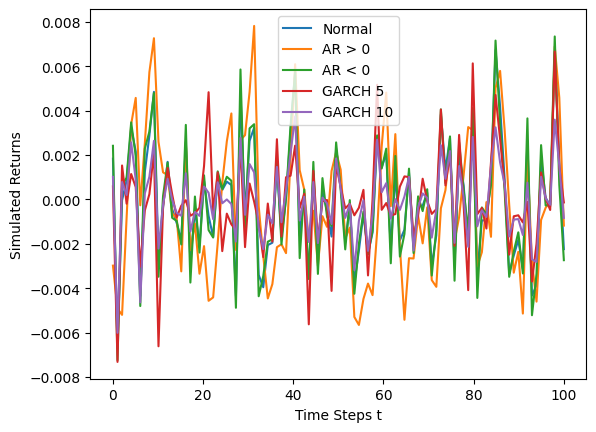

In [ ]:
t = 100

names = ['Normal', 'AR > 0', 'AR < 0', 'GARCH 5', 'GARCH 10']

time_steps = np.linspace(0,t,t)

for i in range(5):
  plt.plot(time_steps,X[burn:burn+t,i],label=names[i])

plt.xlabel('Time Steps t')
plt.ylabel('Simulated Returns')
plt.legend()
plt.show()

# Strategies

The key innovation of the paper is to project the underlying high-dimensional probability distribution of stock returns to a 1D-distribution whose percentile function we can use as part of the loss function. This projection happens through "trading strategies".

A trading strategy is a stochastic process $\phi = ((\phi_t^0,\phi_t^1, \ldots , \phi_t^d))_{t\in \mathbb{T}}$, where $\phi_t^i$ denotes the number of shares of asset $i$ held in the portfolio at time $t$. These are "predictable", meaning that the positions in the portfolio at time $t$ are decided with respect to the information available at time $t - 1$.

If we now define $\mathbf{p} = (p_t, t \in \mathbb{T}) \in \Omega$ as the price trajectories of the assets we're trading on some discrete time set $\mathbb{T}$, then the PnL of the strategy is

$$ \Pi^i (\mathbf{p}) = \sum_{\mathbb{T}} \phi^{i}_{t} (\mathbf{p}) \cdot (p^i_{t + 1} - p^i_t) = \sum_{\mathbb{T}} \phi^{i}_{t} (\mathbf{p}) \cdot r_{t+1}^i $$

a scalar random variable whose distribution is the 1D PnL distribution of that strategy. One can understand these 1D distributions then as features of the high-dimensional probability distribution (or better: its measure $\mathbb{P}$).

One can then use the percentile function and the expectation value of the set under the percentile, which are joint elicitable, to derive a loss function that is tail sensitive.


**TL;DR:** Trading strategies are the assets you hold and their 1D PnL distributions can be used for more efficient and risk-aware learning.

## Implementation

The paper uses static and dynamic trading strategies.

**Static** means we just buy some stocks and hold them until the end of the day (or our trading horizon). The goal here is to learn correlations between stocks.

**Dynamic** means our strategy reacts to changes in prices by buying or selling some stocks as the trading day progresses. These strategies must be implemented as predictable processes, i.e. they can only use the information available at $t$ to adjust the portfolio for $t+1$. The paper describes the use of two types of dynamic strategies (although they don't give any definition):


*   **Mean-Reversion**: If return is positive, bet it will revert (go short); if return is negative, bet it will bounce (go long). The easiest way to implement this is by just inverting the sign of the current return of the stock and change the number of shares you hold accordingly. Ideally we implement some type of moving average / Z-scoring with lookback length $L$:
$$ \phi_{t+1}^i = - \frac{r_t - \mu_{t,L}}{\sigma_{t,L}}$$
Which then also needs to be normalized.
*   **Trend Following**: If returns have been positive, go long; if negative, go short. Essentially the same as before but with a different sign:
$$ \phi_{t+1}^i =  \frac{r_t - \mu_{t,L}}{\sigma_{t,L}}$$


One can implement these two strategies with different types of moving averages or indicators. The expectation is that the algorithm will learn temporal dependencies through these strategies. Further note that we assume here that we can go short, i.e. we can sell stocks that we don't own.

In [ ]:
ArrayLike = Union['torch.Tensor', np.ndarray]
TORCH_AVAILABLE = True

# ---------- Utilities ----------

def _as_torch(x: ArrayLike) -> 'torch.Tensor':
    if not TORCH_AVAILABLE:
        raise RuntimeError("PyTorch is required for torch-based functions.")
    if isinstance(x, torch.Tensor):
        return x
    return torch.as_tensor(x, dtype=torch.float32)


def _to_numpy(x: ArrayLike) -> np.ndarray:
    if isinstance(x, np.ndarray):
        return x
    if TORCH_AVAILABLE and isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x, dtype=np.float32)


def _ema_torch(x: 'torch.Tensor', alpha: float, dim: int) -> 'torch.Tensor':
    """
    Exponential moving average along dim. Causal, starts at x[...,0].
    """
    assert 0.0 < alpha <= 1.0

    # Move target dim to 0 for simple loop; then move back
    perm = list(range(x.ndim))
    perm[dim], perm[0] = perm[0], perm[dim]
    xt = x.permute(*perm)
    out = torch.empty_like(xt)
    out[0] = xt[0]
    for t in range(1, xt.shape[0]):
        out[t] = alpha * xt[t] + (1 - alpha) * out[t - 1]

    # Inverse permute
    inv = list(range(len(perm)))
    for i,p in enumerate(perm):
        inv[p] = i
    return out.permute(*inv)


def _safe_std_torch(x: 'torch.Tensor', dim: int, eps: float = 1e-8) -> 'torch.Tensor':
    mu = x.mean(dim=dim, keepdim=True)
    var = (x - mu).pow(2).mean(dim=dim, keepdim=True)
    return (var + eps).sqrt()


def _soft_sign_torch(x: 'torch.Tensor', slope: float = 2.0, kind: Literal['tanh','softsign']='tanh') -> 'torch.Tensor':
    """
    Smooth approximation of sign(x) with slope controlling sharpness.
    - tanh: sign(x) ~ tanh(slope * x)
    - softsign: x / (|x| + 1/slope)
    """
    if kind == 'tanh':
        return torch.tanh(slope * x)
    elif kind == 'softsign':
        return x * slope / (x.abs() * slope + 1.0)
    else:
        raise ValueError("kind must be 'tanh' or 'softsign'")


In [ ]:
# We implement these strategies using pytorch to ensure easy compatability with the discriminator.
# For mean reversion we have a exponential moving average and simple moving average version



def mean_reversion_zscore_torch(
    r: 'torch.Tensor',
    lookback: int = 20,
    ema: bool = True,
    smooth: bool = True,
    slope: float = 2.0,
    soft_kind: Literal['tanh','softsign'] = 'tanh'
) -> 'torch.Tensor':
    """
    Z-score contrarian: w_{t+1} = - z_t, optionally squashed to [-1,1] via smooth sign.
    """
    rt = _as_torch(r)

    if ema:
        alpha = 2.0 / (lookback + 1.0)
        mu = _ema_torch(rt, alpha=alpha, dim=-2)
        std = _safe_std_torch(rt.unfold(-2, lookback, 1).mean(dim=-1), dim=-2)  # approximate rolling std
        # bring std back to (B,T, A?) by repeating last value for initial warmup
        if rt.ndim == 3:
            B,T,A = rt.shape
            std_full = torch.ones((B,T,A), dtype=rt.dtype, device=rt.device)
        else:
            B,T = rt.shape
            std_full = torch.ones((B,T,1), dtype=rt.dtype, device=rt.device).squeeze(-1)
        std_last = std[..., -1:, : ] if std.ndim==3 else std[..., -1:]
        std_full = std_full * std_last  # crude but stable; avoids long loops

    else:
        # simple rolling mean/std (non-EMA) via unfold
        x = rt if rt.ndim == 3 else rt.unsqueeze(-1)
        u = x.unfold(-2, lookback, 1).mean(dim=-1)
        s = x.unfold(-2, lookback, 1).std(dim=-1, unbiased=False) + 1e-8
        # pad to length T by left-padding first value
        pad = u[..., :1, :]
        mu = torch.cat([pad.repeat_interleave(lookback-1, dim=-2), u], dim=-2)
        pad_s = s[..., :1, :]
        std_full = torch.cat([pad_s.repeat_interleave(lookback-1, dim=-2), s], dim=-2)
        if rt.ndim == 2:
            mu = mu.squeeze(-1)
            std_full = std_full.squeeze(-1)

    z = (rt - mu) / (std_full + 1e-8)
    if smooth:
        s = -_soft_sign_torch(z, slope=slope, kind=soft_kind)  # contrarian
    else:
        s = -torch.sign(z)
    # shift to get w_{t+1}
    pad_shape = list(s.shape)
    pad_shape[-2] = 1
    pad = torch.zeros(pad_shape, dtype=s.dtype, device=s.device)
    w = torch.cat([pad, s[..., :-1, :]] if s.ndim == 3 else [pad.squeeze(-1), s[:, :-1]], dim=-2)
    if w.ndim == 2:
        w = w.unsqueeze(-1)
    return w

In [ ]:
def momentum_ma_cross_torch(
    r: 'torch.Tensor',
    short_lb: int = 10,
    long_lb: int = 40,
    ema: bool = True,
    smooth: bool = True,
    slope: float = 2.0,
    soft_kind: Literal['tanh','softsign'] = 'tanh'
) -> 'torch.Tensor':
    """
    Moving-average crossover on returns (you can also apply on prices).
    Signal_t = MA_short(r) - MA_long(r); w_{t+1} = sign(Signal_t).
    """
    assert long_lb > short_lb >= 1
    rt = _as_torch(r)

    if ema:
        alpha_s = 2.0/(short_lb+1.0)
        alpha_l = 2.0/(long_lb+1.0)
        ma_s = _ema_torch(rt, alpha=alpha_s, dim=-2)
        ma_l = _ema_torch(rt, alpha=alpha_l, dim=-2)
    else:
        x = rt if rt.ndim==3 else rt.unsqueeze(-1)
        ms = x.unfold(-2, short_lb, 1).mean(dim=-1)
        ml = x.unfold(-2, long_lb, 1).mean(dim=-1)
        pad_s = ms[..., :1, :].repeat_interleave(short_lb-1, dim=-2)
        pad_l = ml[..., :1, :].repeat_interleave(long_lb-1, dim=-2)
        ma_s = torch.cat([pad_s, ms], dim=-2)
        ma_l = torch.cat([pad_l, ml], dim=-2)
        if rt.ndim == 2:
            ma_s = ma_s.squeeze(-1)
            ma_l = ma_l.squeeze(-1)

    signal = ma_s - ma_l
    if smooth:
        s = _soft_sign_torch(signal, slope=slope, kind=soft_kind)
    else:
        s = torch.sign(signal)
    pad_shape = list(s.shape)
    pad_shape[-2] = 1
    pad = torch.zeros(pad_shape, dtype=s.dtype, device=s.device)
    w = torch.cat([pad, s[..., :-1, :]] if s.ndim == 3 else [pad.squeeze(-1), s[:, :-1]], dim=-2)
    if w.ndim == 2:
        w = w.unsqueeze(-1)
    return w


In [ ]:
def static_portfolio(
    r: 'torch.tensor',
    a: 'torch.tensor'
    ) -> 'torch.tensor':
    """
    r: (B,T,A), the scenario tensor on which w will act
    a: (A), weight per Asset, will be included in static portfolio according to proportion
    Returns: w, the non-normalized weights for each asset (static) accross whole time horizon
    """
    rt = _as_torch(r)
    B,T,A = rt.shape
    #print(B,T,A)
    w = torch.stack([torch.ones([B,T])*a[i] for i in range(A)], axis=2)
    return w


**Strategy Evaluation Pipeline**

In [ ]:
def portfolio_pnl_torch(
    r: 'torch.Tensor',
    w: 'torch.Tensor',
    weights: Optional['torch.Tensor'] = None,
    l1_normalize: bool = True,
    total_sum: bool = True # If we only need end - start value of portfolio for the given time horizon
) -> 'torch.Tensor':
    """
    Compute per-timestep portfolio PnL for multi-asset series.
    r: (B,T,A), w: (B,T,A)
    weights: optional static asset weights (A,). If None, equal-weight.
    Returns PnL: (B,T) with PnL_{t} = sum_a w_{t,a} * r_{t,a} * weight_a
    """
    rt = _as_torch(r)
    wt = _as_torch(w)
    assert rt.ndim == 3 and wt.ndim == 3 and rt.shape == wt.shape, "r and w must be (B,T,A) and same shape"
    B,T,A = rt.shape
    if weights is None:
        wa = torch.ones(A, dtype=rt.dtype, device=rt.device) / A
    else:
        wa = _as_torch(weights).reshape(A)
        if l1_normalize:
            wa = wa / (wa.abs().sum() + 1e-12)
    pnl = (wt * rt) @ wa  # (B,T,A) @ (A,) -> (B,T)
    if total_sum:
      return pnl.sum(dim=1) # (B,1)
    else:
      return pnl

In [ ]:
def scenario_stacker(X, T=100, burn=2000):
    ''' Stacks the timeseries into T scenarios and returns as torch tensor '''
    Xp = X[burn:]
    Lp = Xp.shape[0]
    num_w = int(Lp//T) -1
    scenarios = np.stack([Xp[i*T:i*T + T] for i in range(num_w)], axis=0)
    return _as_torch(scenarios)

Sanity Check

In [ ]:
# Do shape changes match?
print(X.shape)
scenarios = scenario_stacker(X)
print('Stacked Scenarios: ', scenario_stacker(X).shape)
w = momentum_ma_cross_torch(scenarios)
pnl = portfolio_pnl_torch(scenarios,w)

# Do Values match?
print(pnl[0].sum())
print(portfolio_pnl_torch(scenarios,w,total_sum=True)[0])

#Static Portfolio Checks
print(static_portfolio(scenarios,torch.tensor([0,1,0,0,1])).shape)
print(portfolio_pnl_torch(scenarios, static_portfolio(scenarios, torch.tensor([0,1,0,0,1])), total_sum=True).shape)

NameError: name 'X' is not defined

## Sanity Checks & Intuition

In the following we'll apply the above strategies to a simple wave signal that consists of a sine-wave with wavelength $\lambda_1 = 2$ and another sine-wave with $\lambda_2 = 1/5$. This gives us two different time regimes (short and longterm). As we change the lookback time of a strategy, we'll see an interpolation between the two.

Our step-size is 1/100, so a long-term lookback will be on the order of $l \sim 100$

In [ ]:
TORCH_AVAILABLE = True
x = torch.linspace(0,10,1000).unsqueeze(0).unsqueeze(-1)
y = torch.sin(0.5*(2*torch.pi)*x) + 0.2*torch.sin(5*(2*torch.pi)*x)


EMA Mean Reversion (strategy goes opposite to stock movement)

torch.Size([1, 1000, 1])


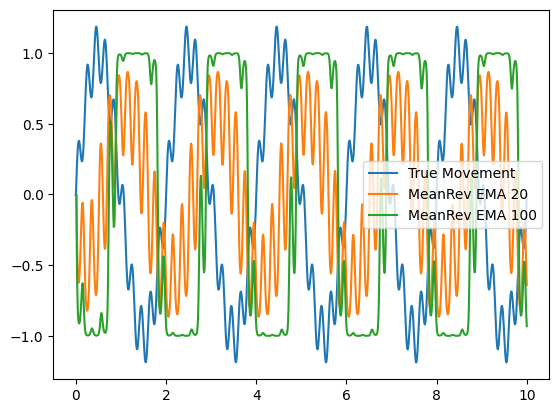

In [ ]:
y_momentum = momentum_ma_cross_torch(y)
y_mean_reversion_20 = mean_reversion_zscore_torch(y,lookback=20)
y_mean_reversion_100 = mean_reversion_zscore_torch(y,lookback=100)

plt.plot(x[0],y[0],label='True Movement')
plt.plot(x[0],y_mean_reversion_20[0], label='MeanRev EMA 20')
plt.plot(x[0],y_mean_reversion_100[0], label='MeanRev EMA 100')


plt.legend()


Simple Moving Average (SMA)

Note the much weaker interpolation

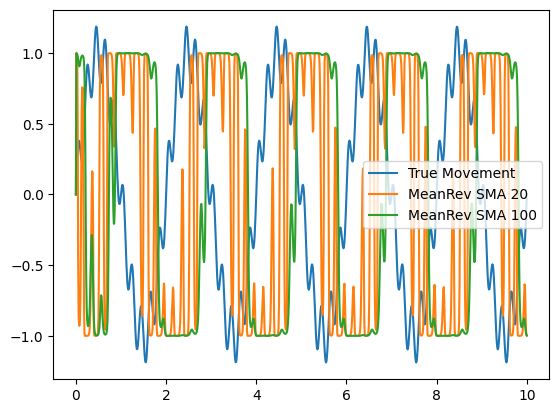

In [ ]:
y_mean_reversion_SMA_20 = mean_reversion_zscore_torch(y,ema=False)
y_mean_reversion_SMA_100 = mean_reversion_zscore_torch(y,lookback=100,ema=False)

plt.plot(x[0],y[0],label='True Movement')
plt.plot(x[0],y_mean_reversion_SMA_20[0], label='MeanRev SMA 20')
plt.plot(x[0],y_mean_reversion_SMA_100[0], label='MeanRev SMA 100')

plt.legend()

Momentum: Moving Average Cross-Over

This consists of two EMAs with different time-scales (lookbacks).

If the two lookbacks are too close together they'll cancel out and the transformed result will be small compared to the ground truth. (Check 30_40)

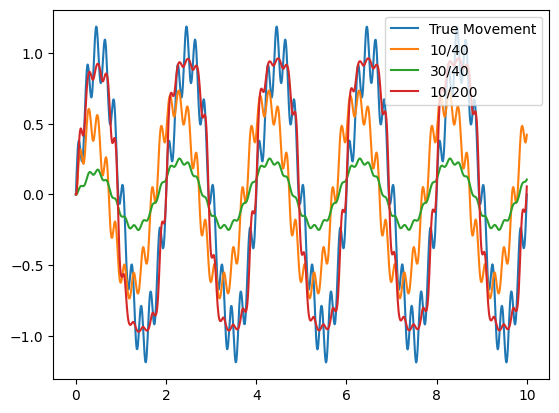

In [ ]:
# Naming: Short weigh, long weigh
y_momentum_10_40 = momentum_ma_cross_torch(y)
y_momentum_30_40 = momentum_ma_cross_torch(y,short_lb=30,long_lb=40)
y_momentum_10_200 = momentum_ma_cross_torch(y,long_lb=200)

plt.plot(x[0],y[0],label='True Movement')
plt.plot(x[0],y_momentum_10_40[0],label='10/40')
plt.plot(x[0],y_momentum_30_40[0],label='30/40')
plt.plot(x[0],y_momentum_10_200[0],label='10/200')

plt.legend()

## Example

In the following I'll give a quick example of the mean reversion strategy with an exponential moving average applied to our synthetic data.
We then compute the **Sharpe Ratio** of our strategy, which is a measure of its excess return in relation to the risk taken (standard deviation in PnL):
$$S = \frac{\mathbb{E} [R_p - R_f]}{\sigma_p}$$

Here $R_p$ is the strategy return and $R_f$ the risk-free rate (i.e. bond yields) which we set to zero here because our synthetic data has mean zero returns (no drift).  

In [ ]:
# Tests
TORCH_AVAILABLE = True

# First we need to reshape our return scenarios into the correct shape needed by our strategies: Scenarios, Timesteps, Assets
rt = _as_torch(X)
returns_scenarios = rt[burn:,].unfold(0,100,100) # Create the scenarios
returns_scenarios = torch.permute(returns_scenarios,(2,0,1)) # Scenarios, Timesteps, Assets
w = mean_reversion_zscore_torch(returns_scenarios,ema=True,lookback=5)


Let's look again at a single trading day consisting of a hundred ticks as per our synthetic data simulation:

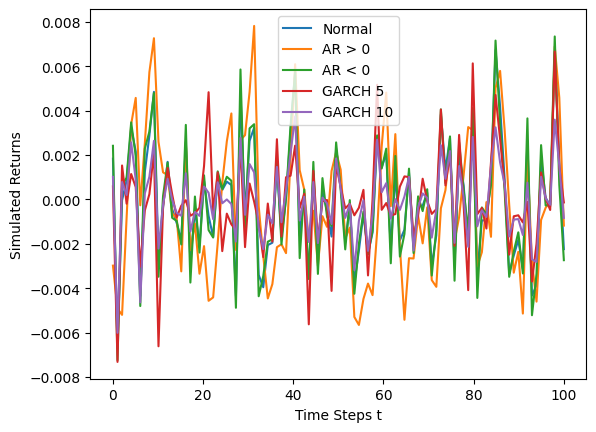

In [ ]:
t = 100

names = ['Normal', 'AR > 0', 'AR < 0', 'GARCH 5', 'GARCH 10']

time_steps = np.linspace(0,t,t)

for i in range(5):
  plt.plot(time_steps,X[burn:burn+t,i],label=names[i])

plt.xlabel('Time Steps t')
plt.ylabel('Simulated Returns')
plt.legend()
plt.show()

Now lets check the portfolio weights that our Mean reversion strategy based on a moving exponential average suggests:

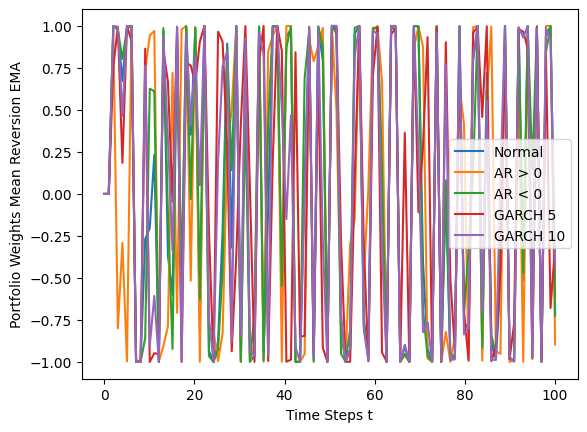

In [ ]:
intval = 100

names = ['Normal', 'AR > 0', 'AR < 0', 'GARCH 5', 'GARCH 10']

time_steps = np.linspace(0,intval,intval)

for i in range(5):
  plt.plot(time_steps,w[0,:intval,i],label=names[i])

plt.xlabel('Time Steps t')
plt.ylabel('Portfolio Weights Mean Reversion EMA')
plt.legend()
plt.show()

Finally, we want to calculate our PnLs, which is the dot product of our strategy with the effective returns.

In [ ]:
pnl = (returns_scenarios * w)

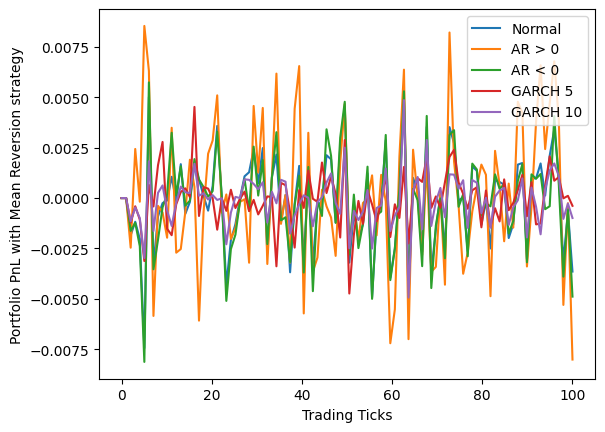

In [ ]:
intval = 100

names = ['Normal', 'AR > 0', 'AR < 0', 'GARCH 5', 'GARCH 10']

time_steps = np.linspace(0,intval,intval)

for i in range(5):
  plt.plot(time_steps,pnl[0,:intval,i],label=names[i])

plt.xlabel('Trading Ticks')
plt.ylabel('Portfolio PnL with Mean Reversion strategy')
plt.legend()
plt.show()

And over the full trading period of 100 days

Note that in the following we are plotting trading days (consisting of 100 ticks each), i.e. the plot does not correlate with the above plots of a single trading day but is the PnL over 100 trading days.

In [ ]:
# Calculate PnL and sum over each trading day
pnl_100 = (returns_scenarios * w).sum(axis=1)

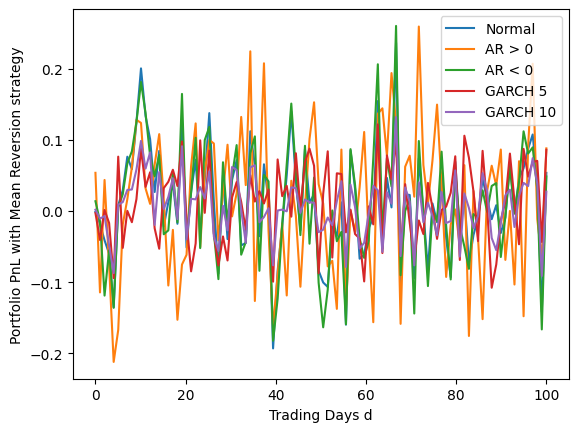

In [ ]:
intval = 100

names = ['Normal', 'AR > 0', 'AR < 0', 'GARCH 5', 'GARCH 10']

time_steps = np.linspace(0,intval,intval)

for i in range(5):
  plt.plot(time_steps,pnl_100[:,i],label=names[i])

plt.xlabel('Trading Days d')
plt.ylabel('Portfolio PnL with Mean Reversion strategy')
plt.legend()
plt.show()

In [ ]:
# Did we make money?
print(pnl.sum())
# yes!

tensor(4.8108)


We have not considered any market microstructures (bid-ask spread, transaction costs, etc).


Let's calculate the sharpe ratio!

In [ ]:
print('Sharpe Ratio: ', pnl.mean()/pnl.std()*np.sqrt(252) )

Sharpe Ratio:  tensor(0.0578)


# GAN

The architecture of Tail-GAN is illustrated in Fig. 2 of the paper:
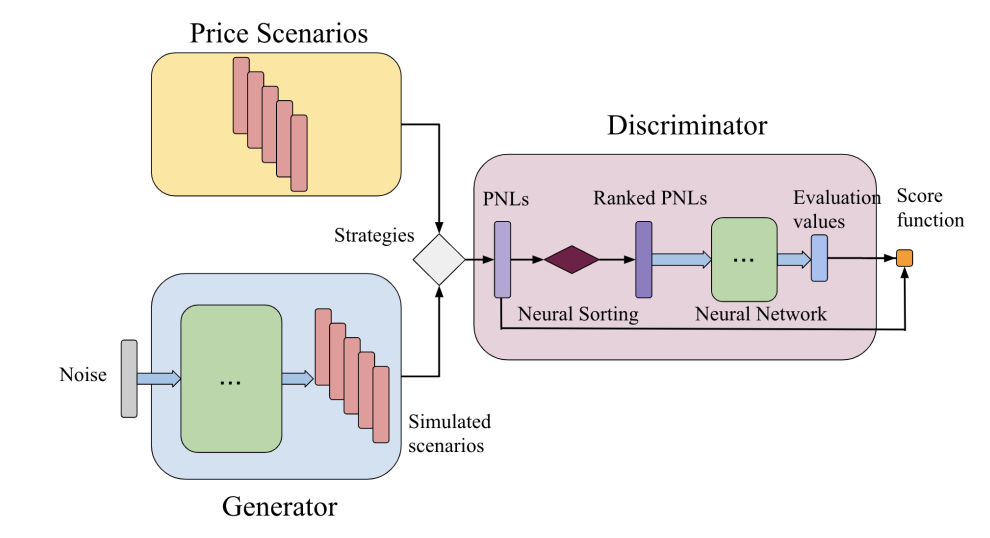


The exact hyperparamteres are described in Appendix C. Though the NNs themselves are just simple FFNNs with leaky ReLus.

## Discriminator

There are two important architectural features of the discriminator:


1.   The discriminator will output two values which will be interepreted as $\alpha$-VaR and $\alpha$-ES and handed as arguments to the score function. (More on that later).
2.   The "Neural Sorting": This refers to a soft-sort algorithm by Grover et al (2019) which can be backpropagated through. Because $\alpha$-VaR of a distribution can be approximated by the $\lfloor \alpha n \rfloor^{\text{th}} $ smallest value in a sample of size $n$, sorting the PnL samples will potentially improve performance.





### Neural-Sorting

We follow the instructions of Appendix C.3 here.

The core idea is to use a soft-max function when constructing the permutation matrix instead of an arg-max function.

In [ ]:
class NeuralSort(nn.Module):
    """
    Differentiable sorting (Grover et al., 2019).
    Given scores s (B, n), returns a soft permutation P_hat (B, n, n)
    and/or the softly sorted vector y = P_hat @ s.
    """
    def __init__(self, return_soft_sorted=True):
        super().__init__()
        self.return_soft_sorted = return_soft_sorted

    @staticmethod
    def _soft_perm(s, tau):
        # s: (B, n)
        B, n = s.shape
        A = torch.abs(s.unsqueeze(-1) - s.unsqueeze(-2))   # (B, n, n)

        # (A_s 1) as a per-item vector, broadcast across positions:
        A1 = A.sum(dim=-1).unsqueeze(1)                    # (B, 1, n)

        idx = torch.arange(1, n+1, device=s.device, dtype=s.dtype)
        c = (n + 1 - 2*idx).view(1, n, 1)                  # (1, n, 1)

        logits = (c * s.unsqueeze(1) - A1) / tau           # (B, n, n)
        return F.softmax(logits, dim=-1)

    def forward(self, s, tau = 1.0):
        # Optional tiny jitter helps break ties for equal elements
        # Change Tau to allow for annealing
        if self.training:
            s = s + 1e-6 * torch.randn_like(s)

        P_hat = self._soft_perm(s, tau)

        if self.return_soft_sorted:
            # y is the softly sorted vector (descending)
            y = torch.bmm(P_hat, s.unsqueeze(-1)).squeeze(-1)           # (B, n)
            return y
        else:
            return P_hat


Some sanity checks

In [ ]:
sorter = NeuralSort()

# An Example
s = torch.tensor([3.0,1.1,5.0,2.0,-1.51]).unsqueeze(0)
print('Sorted Result:', sorter(s,0.5)[0]) # Something is wrong here?
sk = torch.tensor([[3.0,4.0,1.0,2.0,2.5],[7.0,-2.0,3.0,-4.0,1.0]])
print('Sorted Result:', sorter(sk)[0])

Sorted Result: tensor([ 4.9639,  2.9135,  1.9897,  1.2156, -1.4959])
Sorted Result: tensor([3.6537, 2.9656, 2.5000, 2.0344, 1.3463])


I found in training that the discriminator can game the score function a bit. Here we enforce that ES always needs to be smaller than VaR to hinder that behavior

In [ ]:
def enforce_es_leq_var(raw_ev: torch.Tensor) -> torch.Tensor:
    """
    raw_ev: (K,2) unconstrained
    returns: (K,2) with e <= v enforced.
    """
    v_raw = raw_ev[:, 0]
    d_raw = raw_ev[:, 1]
    v = v_raw
    e = v - F.softplus(d_raw)   # e = v - positive => e <= v
    return torch.stack([v, e], dim=1)


### Final Architecture

The architecture is kept as a simple FFNN with leaky ReLus. (To not distract from the effects of the important features discussed above).



In [ ]:

class TailDiscriminator(nn.Module):
    def __init__(self):
        super(TailDiscriminator, self).__init__()
        self.neural_sort = NeuralSort()
        # an affine operation: y = Wx + b
        self.network = nn.Sequential(
            nn.Linear(1000,256),
            nn.LeakyReLU(),
            nn.Linear(256,128),
            nn.LeakyReLU(),
            nn.Linear(128,2)
        )

    def forward(self, input, tau = 1.0):
      sorted_vector = - self.neural_sort(-input, tau) # Sort from smallest to largest for easier handling
      raw = self.network(sorted_vector)
      output = enforce_es_leq_var(raw)
      return output


net = TailDiscriminator()
print(net)

TailDiscriminator(
  (neural_sort): NeuralSort()
  (network): Sequential(
    (0): Linear(in_features=1000, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


## Generator

The generator is just a simple FFNN that produces a scenario (T = 100) for five stocks.

In [ ]:
class TailGenerator(nn.Module):
  def __init__(self):
    super(TailGenerator, self).__init__()
    self.network = nn.Sequential(
        nn.BatchNorm1d(1000),
        nn.Linear(1000,128),
        nn.LeakyReLU(),
        nn.Linear(128,256),
        nn.LeakyReLU(),
        nn.Linear(256,512),
        nn.LeakyReLU(),
        nn.Linear(512,1024),
        nn.LeakyReLU(),
        nn.Linear(1024, 500),
        nn.Unflatten(1, (100, 5))
    )

  def forward(self,input):
      return self.network(input)

gen_net = TailGenerator()
print(gen_net)

TailGenerator(
  (network): Sequential(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1000, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=512, out_features=1024, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=1024, out_features=500, bias=True)
    (10): Unflatten(dim=1, unflattened_size=(100, 5))
  )
)


## Score and Loss Function

They second key ingredient of our architecture, as alluded above, is the score function. What is that?

Consider a functional $T(F)$ mapping from a distribution $F$ to $\mathbb{R}$, e.g. the mean or VaR of a distribution. This functional is said to be elicitable if there exists a strictly proper scoring rule $S(x,y)$ s.t.:

$$ T(F) = \arg \min_{x \in \mathcal{X}} \mathbb{E}_{Y \sim F}[S(x,Y)]$$

In other words, $T(F)$ is elicitable if predicting $x = T(F)$ gives you the best expected score under the true data distribution $F$

An example is the mean which is elicitable under the square error: $S(x,y) = (x-y)^2$. (To see this minimize the expectation value of this score function wrt. x)

**Our Score function**

VaR is elicitable but ES is not. But as it turns out the two are jointly elictable, i.e. we can find a score function $S(e,v,x)$ which is minimized for the correct VaR ($v$) and ES ($e$). For the proof and derivation I'll refer to the paper by Conto et. al.

The score function which jointly elicits the two estimators of tail risks is:

$$S_\alpha (v,e,x) = 5(\mathbb{I}_{\{x \leq v \}} - \alpha)(x^2 -v^2) + \mathbb{I}_{\{x \leq v \}} e(v-x) + \alpha e(\frac{e}{2} -v) $$

We would then evaluate on a sample with size $N$ of the PnL distribution $\Pi^k$ of a strategy $\phi^k$

$$ \mathbb{E}[S^k_\alpha (v,e,x)] =  \frac{1}{N} \sum_{i=1}^{N} S_\alpha(v,e,x_i) \qquad x_i \in \Pi^k $$

As we want autograd to apply to this function, we'll use a sigmoid to approximate the indicator function

In [ ]:
def batch_sum_S_alpha(ev, x, alpha=0.05, tau=0.01):
    """
    ev: (K,2) where ev[:,0]=v and ev[:,1]=e
    x:  (K,N)
    alpha: float, usually 0.05
    tau: temperature for smooth indicator (smaller -> sharper)
    returns: (K,) sum over N for each batch element
    """
    v = ev[:, 0].unsqueeze(1)  # (K,1)
    e = ev[:, 1].unsqueeze(1)  # (K,1)

    # Smooth indicator ~ I{x <= v}
    I = torch.sigmoid((v - x) / tau)  # (K,N)

    term1 = 5 * (I - alpha) * (x.pow(2) - v.pow(2))      # (K,N)
    term2 = I * e * (v - x)                                  # (K,N)
    term3 = alpha * e * (0.5 * e - v)                        # (K,1)  (no x dependence)

    # sum over i=1..N: term3 repeats N times
    N = x.size(1)
    return (term1 + term2).sum(dim=1) + N * term3.squeeze(1)


### Sanity Checks

Using the statistical estimator of a PnL distribution should get us close to the minimum of the above function. As we vary $e$ and $v$ around that minimum, we should see the function increase. (Approx with squared behavior according to Cont et al).

In [ ]:
def var_es(x, alpha=0.05):
    q = np.quantile(x, alpha, method='nearest')
    es = x[x <= q].mean() if np.any(x <= q) else q
    return q, es

# Run
T = 100
burn = 4000 # To allow the GARCH processes to become conditional
L = burn + 120000

X, s, rho, g4, g5 = simulate_X_series(L=L, T=T, seed=109)
P = window_pnl(X, T=T, burn=burn)
print(len(P))
print(P[:,0])
print(P[0,:])
labels = ["Gauss (X1)", "AR φ>0 (X2)", "AR φ<0 (X3)", "GARCH-t ν=5 (X4)", "GARCH-t ν=10 (X5)"]


1199
[ 0.00490229 -0.00122674 -0.00064344 ...  0.0025006   0.00131883
 -0.00295349]
[0.00490229 0.00257379 0.00565154 0.00063957 0.00228719]


In [ ]:
rows = []
for i, label in enumerate(labels):
    v, e = var_es(P[:, i], alpha=0.05)
    rows.append({"Process": label, "VaR 5% (%)": 100*v, "ES 5% (%)": 100*e})

summary = pd.DataFrame(rows)
summary


,Process,VaR 5% (%),ES 5% (%)
0,Gauss (X1),-0.584880,-0.728368
1,AR φ>0 (X2),-0.807587,-0.993633
2,AR φ<0 (X3),-0.654084,-0.813733
3,GARCH-t ν=5 (X4),-0.417414,-0.549236
4,GARCH-t ν=10 (X5),-0.324939,-0.416719


Let's take Process 1 (AR)

It's important to set $\tau$ very small, otherwise the convergence is not as stable around the minima and one might get negative values. This is because for larger $\tau$ the sigmoid function will have a slope that is too shallow.

In [ ]:
pnl = _as_torch(P[:,1]).unsqueeze(0)
e_v = _as_torch(var_es(P[:,1],alpha=0.05)).unsqueeze(0)
print(e_v)

es = torch.linspace(-.5,.5,20)
vs = torch.ones(20)*-0.00807

for i in range(len(es)):
  ev2 = torch.tensor([[vs[i],es[i]]])
  print(batch_sum_S_alpha(ev2,pnl,tau=0.001)/1199)

print('Statistical Estimators: ', batch_sum_S_alpha(e_v,pnl,tau=0.001)/1199)

tensor([[-0.0081, -0.0099]])
tensor([0.0060])
tensor([0.0048])
tensor([0.0037])
tensor([0.0028])
tensor([0.0020])
tensor([0.0013])
tensor([0.0008])
tensor([0.0004])
tensor([0.0001])
tensor([2.1915e-05])
tensor([4.5914e-05])
tensor([0.0002])
tensor([0.0005])
tensor([0.0009])
tensor([0.0015])
tensor([0.0022])
tensor([0.0031])
tensor([0.0041])
tensor([0.0052])
tensor([0.0065])
Statistical Estimators:  tensor([1.4540e-05])


As expected

### Loss Function of the Generator $G$

Let $\gamma$ the trained generator weights and $\delta$ the trained discriminator weights.
From the above we write the loss function of the generator:

$$ \mathcal{L}_G(\gamma) = \frac{1}{KN} \sum_{k=1}^K \sum_{i=1}^{N} S_\alpha \big(D_\delta (\Pi^k (G_\gamma(\mathbf{\vec{z}})), \Pi^k (\mathbf{p}_i)   \big) $$

Here $\mathbf{\vec{z}}$ is the noise vector fed into $G$.

In [ ]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()

    def forward(self,
                pnl_generator: 'torch.Tensor', # (K,M) K = Number of Strategies
                pnl_real: 'torch.Tensor', # (K,M)
                discriminator,
                tau: 'float' = 0.1,
                tau_sort: 'float' = 1.0 ):
      K, M = pnl_generator.shape
      shortfall_VaR = discriminator(pnl_generator, tau = tau_sort) # (K,2)
      score_function = batch_sum_S_alpha(shortfall_VaR,pnl_real,0.05,tau=tau) / M # (K,1)
      return score_function.mean()

### Loss Function of Discriminator

Assuming the same notation as before and with $\lambda$ the dual parameter, we have the following Loss function:

$$ \mathcal{L}_D(\delta) = \frac{1}{KN} \sum_{k=1}^K \sum_{i=1}^{N} \big[ S_\alpha \big(D_\delta (\Pi^k (G_\gamma(\mathbf{\vec{z}})), \Pi^k (\mathbf{p}_i)   \big) - \lambda S_\alpha \big(D_\delta (\Pi^k (\vec{\mathbf{p}}), \Pi^k (\mathbf{p}_i)   \big) \big]$$

Here $\vec{\mathbf{p}}$ is the price vector of real scenarios.

In [ ]:
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()

    def forward(self,
                pnl_generator: 'torch.Tensor', # (K,M) K = Number of Strategies
                pnl_real: 'torch.Tensor', # (K,M)
                discriminator,
                lamb: 'float' = 1.0,
                tau: 'float' = 0.1,
                tau_sort: 'float' = 1.0):
      K, M = pnl_generator.shape
      shortfall_VaR_generator = discriminator(pnl_generator, tau = tau_sort) # (K,2)
      shortfall_VaR_real = discriminator(pnl_real, tau=tau_sort) # (K,2)
      score_function_generator = batch_sum_S_alpha(shortfall_VaR_generator,pnl_real,0.05,tau=tau) / M # (K,1)
      score_function_real = batch_sum_S_alpha(shortfall_VaR_real,pnl_real,0.05,tau=tau) / M # (K,1)
      total_score = score_function_generator - lamb * score_function_real # (K,1)
      return - total_score.mean() # (1), Negative for Maximization

# Performance Monitoring & Evaluation

During and after training we want to evaluate the performance of our various Tail-GANs. The paper uses a variety of measures for this. Thus far I have not implemented all of these measures, though I might once I'm sure that everything runs smoothly.

## During Training

This is just the in-sample average relativ error of tail behavior:

$$ \text{RE}(\mathcal{R}) = \frac{1}{2K} ∑_{k=1}^{K} \big(  \frac{| \text{VaR}_\alpha(\Pi^k, \mathbb{P}_G^{( \mathcal{R})}) - \text{VaR}_\alpha(\Pi^k, \mathbb{P}_r) |}{\text{VaR}_\alpha(\Pi^k, \mathbb{P}_r)} + \frac{| \text{ES}_\alpha(\Pi^k, \mathbb{P}_G^{(\mathcal{R})}) - \text{ES}_\alpha(\Pi^k, \mathbb{P}_r)|}{\text{ES}_\alpha(\Pi^k, \mathbb{P}_r)} \big)$$



In [ ]:
# We assume that the PnLs per strategy have already been calculated,
# as that will happen in the training algorithm. PnL ~ (K,M)

def average_relative_error(pnl_generator: 'torch.Tensor',
                           pnl_real: 'torch.Tensor', # (K,M)
                           alpha: 'float' = 0.05):
                K,M = pnl_real.shape

                var_generator = torch.quantile(pnl_generator, alpha, dim=1 , interpolation='nearest',keepdim=True)
                var_real = torch.quantile(pnl_real, alpha, dim=1, interpolation='nearest',keepdim=True)

                mask_generator = pnl_generator <= var_generator
                mask_real = pnl_real <= var_real

                # mean over tail points (per row)
                tail_sum_gen = (pnl_generator * mask_generator).sum(dim=1)
                tail_count_gen = mask_generator.sum(dim=1).clamp_min(1)               # safety
                es_generator = tail_sum_gen / tail_count_gen

                tail_sum_real = (pnl_real * mask_real).sum(dim=1)
                tail_count_real = mask_real.sum(dim=1).clamp_min(1)               # safety
                es_real = tail_sum_real / tail_count_real

                total_sum = torch.abs(var_generator.squeeze(1) - var_real.squeeze(1)) / torch.abs(var_real.squeeze(1)) + torch.abs(es_generator - es_real) / torch.abs(es_real)

                return total_sum.sum() / (2 * K)



In [ ]:
def empirical_var_es(pnl: 'torch.Tensor',
                 alpha: 'float' = 0.05):
    var_real = torch.quantile(pnl, alpha, dim=1, interpolation='nearest',keepdim=True)
    mask_real = pnl <= var_real

    # mean over tail points (per row)
    tail_sum_real = (pnl * mask_real).sum(dim=1)
    tail_count_real = mask_real.sum(dim=1).clamp_min(1)               # safety
    es_real = tail_sum_real / tail_count_real

    return torch.stack(var_real, es_real, dim=1)

### Sanity Check:
Comparing looped Numpy with vectorized Torch Code to make sure the implementation gives correct results

In [ ]:
def var_es(x, alpha=0.05):
    q = np.quantile(x, alpha, method='nearest')
    es = x[x <= q].mean() if np.any(x <= q) else q
    return q, es

a = torch.randn(2, 100)
print(a.shape)
a_numpy = _to_numpy(a)

print('Original Numpy Method for Row 1: ', var_es(a_numpy[1]))


# If we now apply the vectorized torch method we should find that the second row of our results corresponds to the above
torch_var = torch.quantile(a, 0.05, dim=1 , interpolation='nearest',keepdim=True)

mask = a <= torch_var

tail_sum_gen = (a * mask).sum(dim=1)
tail_count_gen = mask.sum(dim=1).clamp_min(1)               # safety
es_generator = tail_sum_gen / tail_count_gen

print('Torch Vectorized Results: ', torch_var,es_generator)
print(torch_var.squeeze(1) - es_generator)
# Good

torch.Size([2, 100])
Original Numpy Method for Row 1:  (np.float32(-1.7280153), np.float32(-2.1477394))
Torch Vectorized Results:  tensor([[-1.6905],
        [-1.7280]]) tensor([-2.4822, -2.1477])
tensor([0.7917, 0.4197])


## Post Training



In [ ]:
from typing import Tuple

def price_increments_torch(X: torch.Tensor) -> torch.Tensor:
    """
    X: (N, T, A) price scenarios (levels)
    returns: (N, T-1, A) increments
    """
    return X[:, 1:, :] - X[:, :-1, :]

def corr_matrix_from_increments_torch(dX: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    dX: (N, T-1, A)
    returns: (A, A) correlation matrix across assets, pooling all N*(T-1) observations.
    """
    # Use float64 for numerical stability, then cast back if you want
    Y = dX.reshape(-1, dX.shape[-1]).to(torch.float64)  # (n_obs, A)
    Y = Y - Y.mean(dim=0, keepdim=True)

    n = Y.shape[0]
    denom = max(n - 1, 1)
    cov = (Y.T @ Y) / denom  # (A, A)

    var = torch.diag(cov).clamp_min(eps)
    std = torch.sqrt(var)
    corr = cov / (std[:, None] * std[None, :])

    corr = corr.clamp(-1.0, 1.0)
    corr.fill_diagonal_(1.0)
    return corr

def acf_from_increments_torch(dX: torch.Tensor, max_lag: int = 10, eps: float = 1e-12) -> torch.Tensor:
    """
    dX: (N, T-1, A)
    returns: (A, max_lag) autocorr per asset for lags 1..max_lag
             pooling across all scenarios and valid times.
    """
    dX64 = dX.to(torch.float64)
    N, Tp, A = dX64.shape
    L = max_lag

    acf = torch.empty((A, L), device=dX.device, dtype=torch.float64)
    acf.fill_(float("nan"))

    # Loop over lags (cheap: max 10) and compute per-asset correlations vectorized over assets
    for lag in range(1, L + 1):
        if lag >= Tp:
            continue

        x = dX64[:, :-lag, :]  # (N, Tp-lag, A)
        y = dX64[:, lag:,  :]  # (N, Tp-lag, A)

        # Flatten across scenarios and time
        x = x.reshape(-1, A)
        y = y.reshape(-1, A)

        x = x - x.mean(dim=0, keepdim=True)
        y = y - y.mean(dim=0, keepdim=True)

        cov = (x * y).mean(dim=0)  # (A,)
        sx = torch.sqrt((x * x).mean(dim=0).clamp_min(eps))
        sy = torch.sqrt((y * y).mean(dim=0).clamp_min(eps))

        acf[:, lag - 1] = cov / (sx * sy)

    return acf

def dependence_scores_torch(
    X_real: torch.Tensor,
    X_gen: torch.Tensor,
    max_lag: int = 10,
    use_upper_triangle_only: bool = False,
    eps: float = 1e-12,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Returns:
      corr_real, corr_gen, corr_score,
      acf_real,  acf_gen,  acf_score

    Scores are sums of absolute differences, matching what the paper reports
    for correlation matrices and ACF curves (lags 1..10).
    """
    dX_real = price_increments_torch(X_real)
    dX_gen  = price_increments_torch(X_gen)

    corr_real = corr_matrix_from_increments_torch(dX_real, eps=eps)
    corr_gen  = corr_matrix_from_increments_torch(dX_gen,  eps=eps)

    if use_upper_triangle_only:
        iu = torch.triu_indices(corr_real.shape[0], corr_real.shape[1], offset=1, device=X_real.device)
        corr_score = (corr_real[iu[0], iu[1]] - corr_gen[iu[0], iu[1]]).abs().sum()
    else:
        corr_score = (corr_real - corr_gen).abs().sum()

    acf_real = acf_from_increments_torch(dX_real, max_lag=max_lag, eps=eps)
    acf_gen  = acf_from_increments_torch(dX_gen,  max_lag=max_lag, eps=eps)

    # Ignore NaNs (in case Tp <= max_lag)
    acf_diff = (acf_real - acf_gen).abs()
    acf_score = torch.nan_to_num(acf_diff, nan=0.0).sum()

    return corr_real, corr_gen, corr_score, acf_real, acf_gen, acf_score


# Training

We now proceed to write the training loop. In order to do so we need:

- Generation of 50K price scenarios
- For each Tail-GAN a function that transforms all price scenarios according to the $K$ strategies selected. ( what I call "Strategy Stackers")


## Strategy Stackers

The Tail-GAN paper trains 3 different GAN models, (1) Tail-GAN-Raw which is only trained on single-asset static (buy-and-hold) portfolios, (2) Tail-GAN-Static which is trained on multi-asset static portfolios and (3) Tail-GAN which is trained on both static and dynamic multi-asset portfolios.

Below we will create a function stacker for each of these cases. This, in general, leads to a lot of repetitive code as we are essentially just implementing the strategies written in a previous section with different arguments and stack their results

**Raw Strategies**

Single-Asset

In [ ]:
def raw_strategies(r: 'torch.tensor' # (B,T,A)
                   ):
  asset_choices = [torch.tensor([1,0,0,0,0]), torch.tensor([0,1,0,0,0]), torch.tensor([0,0,1,0,0]),
                   torch.tensor([0,0,0,1,0]), torch.tensor([0,0,0,0,1])]
  #print('Evaluating Strategies')

  return torch.stack([portfolio_pnl_torch(r, static_portfolio(r, a), total_sum=True) for a in asset_choices], axis=0)


In [ ]:
RAW_W = torch.tensor([
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1]
], dtype=torch.float32)  # (K,A)

def raw_strategies_fast(r: torch.Tensor) -> torch.Tensor:
    # r: (B,T,A)
    rt = _as_torch(r)
    W = RAW_W.to(device=rt.device, dtype=rt.dtype)  # (K,A)
    A = rt.shape[2]

    # (wt*rt) @ (1/A) then sum over time
    per_t = torch.einsum("bta,ka->kbt", rt, W) / A      # (K,B,T)
    return per_t.sum(dim=2)                             # (K,B)


**Static Strategies**

Multi-Asset Portfolios (buy and hold)

In [ ]:
def static_strategies(r: 'torch.tensor' # (B,T,A)
                   ):
  asset_choices = [torch.tensor([1,1,0,0,0]), torch.tensor([0,1,1,0,0]), torch.tensor([0,0,1,1,0]),
                   torch.tensor([0,0,0,1,1]), torch.tensor([1,0,0,0,1]), torch.tensor([1,0,1,0,0]),
                   torch.tensor([1,0,0,1,0]), torch.tensor([0,1,0,1,0]), torch.tensor([0,1,0,0,1]),
                   torch.tensor([0,0,1,0,1]), torch.tensor([1,1,1,0,0]), torch.tensor([0,1,1,1,0]),
                   torch.tensor([0,0,1,1,1]), torch.tensor([1,1,0,0,1]), torch.tensor([1,1,0,1,0]),
                   torch.tensor([1,0,1,0,1]), torch.tensor([0,1,1,0,1]), torch.tensor([1,1,1,1,0]),
                   torch.tensor([0,1,1,1,1]), torch.tensor([1,1,1,1,1])]
  #print('Evaluating Strategies')

  return torch.stack([portfolio_pnl_torch(r, static_portfolio(r, a), total_sum=True) for a in asset_choices], axis=0)


In [ ]:
STATIC_W = torch.tensor([
    [1,1,0,0,0], [0,1,1,0,0], [0,0,1,1,0], [0,0,0,1,1], [0,0,0,1,1], [1,0,0,0,1],
    [1,0,1,0,0], [1,0,0,1,0], [0,1,0,1,0], [0,1,0,0,1], [0,0,1,0,1], [1,1,1,0,0],
    [0,1,1,1,0], [0,0,1,1,1], [1,1,0,0,1], [1,1,0,1,0], [1,0,1,0,1], [0,1,1,0,1],
    [1,1,1,1,0], [0,1,1,1,1], [1,1,1,1,1]
], dtype=torch.float32)  # (K,A)

def static_strategies_fast(r: torch.Tensor) -> torch.Tensor:
    # r: (B,T,A)
    rt = _as_torch(r)
    W = STATIC_W.to(device=rt.device, dtype=rt.dtype)  # (K,A)
    A = rt.shape[2]

    # (wt*rt) @ (1/A) then sum over time
    per_t = torch.einsum("bta,ka->kbt", rt, W) / A      # (K,B,T)
    return per_t.sum(dim=2)                             # (K,B)


**Dynamic Strategies**



In [ ]:
def dynamic_strategies(r: 'torch.tensor'
                       ):
  dynamic_pnls = []

  dynamic_pnls.append(portfolio_pnl_torch(r, mean_reversion_zscore_torch(r, lookback=3)))
  dynamic_pnls.append(portfolio_pnl_torch(r, mean_reversion_zscore_torch(r, lookback=6)))

  dynamic_pnls.append(portfolio_pnl_torch(r, mean_reversion_zscore_torch(r, lookback=3,ema=False)))
  dynamic_pnls.append(portfolio_pnl_torch(r, mean_reversion_zscore_torch(r, lookback=6,ema=False)))

  dynamic_pnls.append(portfolio_pnl_torch(r, momentum_ma_cross_torch(r, 3, 8)))
  dynamic_pnls.append(portfolio_pnl_torch(r, momentum_ma_cross_torch(r, 2, 6)))
  dynamic_pnls.append(portfolio_pnl_torch(r, momentum_ma_cross_torch(r, 3, 8, ema=False)))

  return torch.stack(dynamic_pnls)



torch.Size([7, 10000])


## Data Generation

In [ ]:
# Keep the generated Parameters for later reference ( 11s per Batch, want 3k batches = approx 8h of data generation....)
X, s, rho, g4, g5 = simulate_X_series(1002100,seed=109)


NameError: name 'scenario_stacker' is not defined

In [ ]:
training_scenarios = scenario_stacker(X)
print(training_scenarios.shape)

torch.Size([10000, 100, 5])


Sanity Check that vectorized agrees with simple stacked approach

In [ ]:
print(raw_strategies(training_scenarios).shape)
print(static_strategies_fast(training_scenarios).shape)

print(raw_strategies(training_scenarios))
print(raw_strategies_fast(training_scenarios))

torch.Size([5, 10000])
torch.Size([21, 10000])
tensor([[-0.0050, -0.0078,  0.0010,  ..., -0.0100, -0.0046, -0.0023],
        [-0.0026, -0.0148, -0.0010,  ..., -0.0219, -0.0120,  0.0016],
        [-0.0045, -0.0075,  0.0009,  ..., -0.0097, -0.0045, -0.0017],
        [-0.0046, -0.0029,  0.0029,  ..., -0.0011, -0.0004, -0.0026],
        [-0.0034, -0.0040,  0.0004,  ..., -0.0063, -0.0021, -0.0027]])
tensor([[-0.0050, -0.0078,  0.0010,  ..., -0.0100, -0.0046, -0.0023],
        [-0.0026, -0.0148, -0.0010,  ..., -0.0219, -0.0120,  0.0016],
        [-0.0045, -0.0075,  0.0009,  ..., -0.0097, -0.0045, -0.0017],
        [-0.0046, -0.0029,  0.0029,  ..., -0.0011, -0.0004, -0.0026],
        [-0.0034, -0.0040,  0.0004,  ..., -0.0063, -0.0021, -0.0027]])


## General Training Loop

In [ ]:
def train_loop(dataloader, generator, discriminator,
               gen_loss, disc_loss,
               gen_optimizer, disc_optimizer,
               noise_dist, strategies, error, tau_indicator = 0.001, tau_sort = 0.1):

    generator.train()
    discriminator.train()

    device = next(generator.parameters()).device

    for step, pnl_batch in enumerate(dataloader):

        pnl_real = pnl_batch.to(device, non_blocking=True).T.contiguous() # Need to transpose again to be coherent with trafos
        K, B = pnl_real.shape

        # -------------------------
        # 1) Train Discriminator
        # -------------------------
        disc_optimizer.zero_grad(set_to_none=True)

        z = noise_dist.sample((B, 1000))
        with torch.no_grad():
            X_fake = generator(z)           # no G grads in D step
        # or: X_fake = generator(z).detach()

        pnl_fake = strategies(X_fake)

        loss_D = disc_loss(pnl_fake, pnl_real, discriminator, tau=tau_indicator, tau_sort=tau_sort)
        loss_D.backward()
        disc_optimizer.step()

        # -------------------------
        # 2) Train Generator
        # -------------------------
        # Freeze D params so we don't compute/store grads for them
        for p in discriminator.parameters():
            p.requires_grad_(False)

        gen_optimizer.zero_grad(set_to_none=True)

        z = noise_dist.sample((B, 1000))
        X_fake = generator(z)               # allow G grads
        pnl_fake = strategies(X_fake)


        loss_G = gen_loss(pnl_fake, pnl_real, discriminator, tau=tau_indicator, tau_sort=tau_sort)
        loss_G.backward()
        gen_optimizer.step()

        # Unfreeze D for next iteration
        for p in discriminator.parameters():
            p.requires_grad_(True)

        if step % 15 == 0:
            lossG, lossD, current = loss_G.item(), loss_D.item(),  step * B + B
            avg_error = error(pnl_fake,pnl_real)
            print(f"G-loss: {lossG:>7f}, D-loss: {lossD:>7f}   [{current:>5d}]   Avg. error:  {avg_error:>7f}")

    Disc_Sched.step()
    Gen_Sched.step()

## Tail-GAN-Raw

Initialization and Setup

In [ ]:

TailGanRaw_Generator = TailGenerator().to(device)
TailGanRaw_Discriminator = TailDiscriminator().to(device)
Raw_GenLoss = GeneratorLoss().to(device)
Raw_DiscLoss = DiscriminatorLoss().to(device)

# Gen_Optim = torch.optim.SGD(TailGanRaw_Generator.parameters(), lr = 10e-6)
# Disc_Optim = torch.optim.SGD(TailGanRaw_Discriminator.parameters(), lr = 10e-7)


# Training Data and White Noise Sampling (Paper uses t(5) for white noise)
pnl_real_raw = raw_strategies_fast(training_scenarios).T.contiguous()
train_dataloader_raw = DataLoader(pnl_real_raw,1000,  pin_memory=True) # num_workers=2, persistent_workers=True

dist = torch.distributions.StudentT(
    df=torch.tensor(5.0, device=device, dtype=torch.float32)
)


In [ ]:
def make_warmup_cosine_scheduler(optimizer, epochs, warmup_epochs=100, min_lr_frac=0.05):
    """
    Epoch-based warmup + cosine decay.
    Call scheduler.step() once per epoch.
    """
    warmup_epochs = max(1, int(warmup_epochs))
    epochs = int(epochs)
    min_lr_frac = float(min_lr_frac)

    def lr_lambda(epoch: int):
        # epoch is 0-based
        if epoch < warmup_epochs:
            # Linear warmup: from min_lr_frac to 1.0
            return min_lr_frac + (1.0 - min_lr_frac) * (epoch + 1) / warmup_epochs

        # Cosine decay: from 1.0 down to min_lr_frac
        t = (epoch - warmup_epochs) / max(1, (epochs - warmup_epochs))
        t = min(max(t, 0.0), 1.0)
        return min_lr_frac + 0.5 * (1.0 - min_lr_frac) * (1.0 + math.cos(math.pi * t))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


# ---- Setup for 3000 epochs ----
EPOCHS = 3000

Gen_Optim  = torch.optim.Adam(TailGanRaw_Generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
Disc_Optim = torch.optim.Adam(TailGanRaw_Discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))

Gen_Sched  = make_warmup_cosine_scheduler(Gen_Optim,  epochs=EPOCHS, warmup_epochs=100, min_lr_frac=0.05)
Disc_Sched = make_warmup_cosine_scheduler(Disc_Optim, epochs=EPOCHS, warmup_epochs=100, min_lr_frac=0.05)

Training Loop

### Training

In [ ]:
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    tau_indicator = 1 / (1000 + epoch)
    tau_sort = 100 / (100 + epoch)
    train_loop(train_dataloader_raw, TailGanRaw_Generator, TailGanRaw_Discriminator, Raw_GenLoss,
           Raw_DiscLoss, Gen_Optim, Disc_Optim, dist, raw_strategies_fast, average_relative_error, tau_indicator = tau_indicator,
               tau_sort=tau_sort)

    if epoch % 50 == 0:
      print("epoch", epoch,
            "lr_D", Disc_Optim.param_groups[0]["lr"],
            "lr_G", Gen_Optim.param_groups[0]["lr"])
print("Done!")

Epoch 1
-------------------------------
G-loss: -0.098766, D-loss: -0.005428   [ 1000]   Avg. error:  3.659597
G-loss: -0.100582, D-loss: -0.003487   [16000]   Avg. error:  2.435766
G-loss: -0.099899, D-loss: -0.004429   [31000]   Avg. error:  2.335270
epoch 0 lr_D 6.900000000000001e-06 lr_G 6.900000000000001e-06
Epoch 2
-------------------------------
G-loss: -0.099873, D-loss: -0.004587   [ 1000]   Avg. error:  2.104415
G-loss: -0.099974, D-loss: -0.004374   [16000]   Avg. error:  1.614919
G-loss: -0.100426, D-loss: -0.003862   [31000]   Avg. error:  1.167768
Epoch 3
-------------------------------
G-loss: -0.100941, D-loss: -0.003777   [ 1000]   Avg. error:  1.057266
G-loss: -0.101517, D-loss: -0.002868   [16000]   Avg. error:  0.812775
G-loss: -0.101940, D-loss: -0.002342   [31000]   Avg. error:  0.715461
Epoch 4
-------------------------------
G-loss: -0.102458, D-loss: -0.002332   [ 1000]   Avg. error:  0.552305
G-loss: -0.102852, D-loss: -0.001461   [16000]   Avg. error:  0.5890

KeyboardInterrupt: 

## Tail-Gan-Static

In [ ]:

TailGanStatic_Generator = TailGenerator().to(device)
TailGanStatic_Discriminator = TailDiscriminator().to(device)
Static_GenLoss = GeneratorLoss().to(device)
Static_DiscLoss = DiscriminatorLoss().to(device)

# Training Data and White Noise Sampling (Paper uses t(5) for white noise)
pnl_real_static = static_strategies_fast(training_scenarios).T.contiguous()
train_dataloader_static = DataLoader(pnl_real_static,1000)

dist = torch.distributions.StudentT(
    df=torch.tensor(5.0, device=device, dtype=torch.float32)
)


In [ ]:
def make_warmup_cosine_scheduler(optimizer, epochs, warmup_epochs=100, min_lr_frac=0.05):
    """
    Epoch-based warmup + cosine decay.
    Call scheduler.step() once per epoch.
    """
    warmup_epochs = max(1, int(warmup_epochs))
    epochs = int(epochs)
    min_lr_frac = float(min_lr_frac)

    def lr_lambda(epoch: int):
        # epoch is 0-based
        if epoch < warmup_epochs:
            # Linear warmup: from min_lr_frac to 1.0
            return min_lr_frac + (1.0 - min_lr_frac) * (epoch + 1) / warmup_epochs

        # Cosine decay: from 1.0 down to min_lr_frac
        t = (epoch - warmup_epochs) / max(1, (epochs - warmup_epochs))
        t = min(max(t, 0.0), 1.0)
        return min_lr_frac + 0.5 * (1.0 - min_lr_frac) * (1.0 + math.cos(math.pi * t))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


# ---- Setup for 3000 epochs ----
EPOCHS = 3000

Gen_Optim_Static  = torch.optim.Adam(TailGanStatic_Generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
Disc_Optim_Static = torch.optim.Adam(TailGanStatic_Discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))

Gen_Sched_Static  = make_warmup_cosine_scheduler(Gen_Optim_Static,  epochs=EPOCHS, warmup_epochs=100, min_lr_frac=0.05)
Disc_Sched_Static = make_warmup_cosine_scheduler(Disc_Optim_Static, epochs=EPOCHS, warmup_epochs=100, min_lr_frac=0.05)

### Training

In [ ]:
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    tau_indicator = 1 / (1000 + epoch)
    tau_sort = 100 / (100 + epoch)
    train_loop(train_dataloader_static, TailGanStatic_Generator, TailGanStatic_Discriminator, Static_GenLoss,
           Static_DiscLoss, Gen_Optim_Static, Disc_Optim_Static, dist, static_strategies_fast, average_relative_error, tau_indicator = tau_indicator,
               tau_sort=tau_sort)

    if epoch % 50 == 0:
      print("epoch", epoch,
            "lr_D", Disc_Optim_Static.param_groups[0]["lr"],
            "lr_G", Gen_Optim_Static.param_groups[0]["lr"])
print("Done!")

Epoch 1
-------------------------------
G-loss: -0.004129, D-loss: -0.001257   [ 1000]   Avg. error:  1.744063
G-loss: -0.003406, D-loss: -0.000833   [16000]   Avg. error:  1.370839
G-loss: -0.001765, D-loss: -0.001817   [31000]   Avg. error:  1.029262


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


epoch 0 lr_D 5.950000000000001e-06 lr_G 5.950000000000001e-06
Epoch 2
-------------------------------
G-loss: -0.002164, D-loss: -0.001951   [ 1000]   Avg. error:  0.779585
G-loss: -0.001743, D-loss: -0.001422   [16000]   Avg. error:  0.448800
G-loss: -0.001572, D-loss: -0.001028   [31000]   Avg. error:  0.394550
Epoch 3
-------------------------------
G-loss: -0.002339, D-loss: -0.000823   [ 1000]   Avg. error:  0.332085
G-loss: -0.001484, D-loss: -0.000166   [16000]   Avg. error:  0.343584
G-loss: -0.000908, D-loss: -0.000001   [31000]   Avg. error:  0.315097
Epoch 4
-------------------------------
G-loss: -0.001498, D-loss: 0.000087   [ 1000]   Avg. error:  0.329334
G-loss: -0.000925, D-loss: 0.000583   [16000]   Avg. error:  0.290782
G-loss: -0.000976, D-loss: 0.000418   [31000]   Avg. error:  0.309428
Epoch 5
-------------------------------
G-loss: -0.001953, D-loss: 0.000419   [ 1000]   Avg. error:  0.324678
G-loss: -0.001831, D-loss: 0.000300   [16000]   Avg. error:  0.308031
G-

KeyboardInterrupt: 

## Tail-Gan Dynamic

In [ ]:

TailGanDynamic_Generator = TailGenerator().to(device)
TailGanDynamic_Discriminator = TailDiscriminator().to(device)
Dynamic_GenLoss = GeneratorLoss().to(device)
Dynamic_DiscLoss = DiscriminatorLoss().to(device)

# Training Data and White Noise Sampling (Paper uses t(5) for white noise)
pnl_real_dynamic = dynamic_strategies(training_scenarios).T.contiguous()
train_dataloader_dynamic = DataLoader(pnl_real_dynamic,1000)

dist = torch.distributions.StudentT(
    df=torch.tensor(5.0, device=device, dtype=torch.float32)
)


In [ ]:
def make_warmup_cosine_scheduler(optimizer, epochs, warmup_epochs=100, min_lr_frac=0.05):
    """
    Epoch-based warmup + cosine decay.
    Call scheduler.step() once per epoch.
    """
    warmup_epochs = max(1, int(warmup_epochs))
    epochs = int(epochs)
    min_lr_frac = float(min_lr_frac)

    def lr_lambda(epoch: int):
        # epoch is 0-based
        if epoch < warmup_epochs:
            # Linear warmup: from min_lr_frac to 1.0
            return min_lr_frac + (1.0 - min_lr_frac) * (epoch + 1) / warmup_epochs

        # Cosine decay: from 1.0 down to min_lr_frac
        t = (epoch - warmup_epochs) / max(1, (epochs - warmup_epochs))
        t = min(max(t, 0.0), 1.0)
        return min_lr_frac + 0.5 * (1.0 - min_lr_frac) * (1.0 + math.cos(math.pi * t))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


# ---- Setup for 3000 epochs ----
EPOCHS = 3000

Gen_Optim_Dynamic  = torch.optim.Adam(TailGanDynamic_Generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
Disc_Optim_Dynamic = torch.optim.Adam(TailGanDynamic_Discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))

Gen_Sched_Dynamic  = make_warmup_cosine_scheduler(Gen_Optim_Dynamic,  epochs=EPOCHS, warmup_epochs=100, min_lr_frac=0.05)
Disc_Sched_Dynamic = make_warmup_cosine_scheduler(Disc_Optim_Dynamic, epochs=EPOCHS, warmup_epochs=100, min_lr_frac=0.05)

### Training

In [ ]:
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    tau_indicator = 1 / (1000 + epoch)
    tau_sort = 100 / (100 + epoch)
    train_loop(train_dataloader_dynamic, TailGanDynamic_Generator, TailGanDynamic_Discriminator, Dynamic_GenLoss,
           Dynamic_DiscLoss, Gen_Optim_Dynamic, Disc_Optim_Dynamic, dist, Dynamic_strategies, average_relative_error, tau_indicator = tau_indicator,
               tau_sort=tau_sort)

    ev_pred = TailGanDynamic_Discriminator(pnl_real_dynamic)
    ev_emp = empirical_var_es(pnl_real_dynamic)
    print('EV Prediction: ',|pred - emp|)

    if epoch % 50 == 0:
      print("epoch", epoch,
            "lr_D", Disc_Optim_Dynamic.param_groups[0]["lr"],
            "lr_G", Gen_Optim_Dynamic.param_groups[0]["lr"])
print("Done!")

# Evaluation & Conclusion

# Appendix

Old Code snippets that I might need to come back to

In [ ]:
def simulate_X(T, phi1=0.5, phi2=-0.15,
               nu1=5, nu2=10, R=None, seed=None):

    if seed is not None:
      np.random.seed(seed)

    if R is None:
        rho = np.random.rand(5,5)
        rho = (rho + rho.T)/2 # symmetry
        np.fill_diagonal(rho, 1.0) # correlation matrix has ones on diagonal

        s = np.random.uniform(0.3,0.5,5) # annualized stdv
        covariance_matrix = np.outer(s, s) * rho  / (255*T)

    # correlated Gaussian base
    u = np.random.multivariate_normal(np.zeros(5), covariance_matrix, size=T)

    # draw variety of GARCH parameters according to Appendic C.1 in the paper
    kappa4,kappa5 = np.random.uniform(0.08,0.12,2)
    beta4,beta5 = np.random.uniform(0.825,0.875,2)
    gamma4,gamma5 = np.random.uniform(0.03,0.07,2)

    X = np.zeros((T, 5))
    sigma4 = np.zeros(T)
    sigma5 = np.zeros(T)
    sigma4[0] = np.sqrt(gamma4)
    sigma5[0] = np.sqrt(gamma5) #np.sqrt(gamma4 / (1 - kappa4 - beta4))


    for t in range(1, T):
        # X1: iid
        X[t, 0] = u[t, 0]

        # X2, X3: AR(1)
        X[t, 1] = phi1 * X[t-1, 1] + u[t, 1]
        X[t, 2] = phi2 * X[t-1, 2] + u[t, 2]

        # X4, X5: GARCH(1,1) with t noise
        v1 = chi2.rvs(df=nu1)
        v2 = chi2.rvs(df=nu2)
        eta4 = u[t,3]/np.sqrt(v1/nu1) #stud t with correlated gaussian core distribution
        eta5 = u[t,4]/np.sqrt(v2/nu2)
        sigma4[t] = np.sqrt(gamma4 + kappa4 * X[t-1, 3]**2 + beta4 * sigma4[t-1]**2)
        sigma5[t] = np.sqrt(gamma5 + kappa5 * X[t-1, 4]**2 + beta5 * sigma5[t-1]**2)
        X[t, 3] = sigma4[t] * eta4
        X[t, 4] = sigma5[t] * eta5

    return X
